<a href="https://colab.research.google.com/github/sabillahm/Thesis-Code/blob/main/1_iterasi_VGG16_CLAHE_0%2C001_16_100_Versi1_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Import Libraries and Setup Device
"""
This cell imports all the necessary libraries and sets up the device for GPU computation if available.
We are using PyTorch for deep learning, OpenCV for image processing, and Matplotlib/Seaborn for visualization.
"""

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import cv2
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from tqdm import tqdm
import os
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Cek apakah kode dijalankan di Google Colab
IN_COLAB = 'google.colab' in str(get_ipython())

# Cek apakah GPU tersedia, jika tidak gunakan CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Mount Google Drive jika menggunakan Google Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


Using device: cuda
Mounted at /content/drive


# Cell 2: Define Data Loading and Preprocessing Functions
"""
This cell contains functions to load and preprocess images from the dataset.
The `load_data` function loads images from the specified directory and assigns labels based on the folder structure.
The `preprocess_image` function applies CLAHE and unsharp masking to enhance image quality.
The `CustomDataset` class integrates these functions and prepares the dataset for use in PyTorch.
"""

In [ ]:
def load_data(dataset_path, subset):
    images = []
    labels = []

    # Tentukan label sesuai dengan subset

    label_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']



    # Pemetaan nama label ke indeks
    label_map = {name: idx for idx, name in enumerate(label_names)}

    subset_path = os.path.join(dataset_path, subset)
    for label_name in label_names:
        image_dir = os.path.join(subset_path, label_name)
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Directory not found: {image_dir}")
        for file_name in os.listdir(image_dir):
            if file_name.endswith('.png'):  # Cek jika file adalah gambar PNG
                image_path = os.path.join(image_dir, file_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: Unable to load image {image_path}")
                    continue
                images.append(image)
                labels.append(label_map[label_name])
                print(f"Loaded image {image_path}")
    return images, labels

def preprocess_image(image):
    if image is None or image.size == 0:
        raise ValueError("Empty image provided for preprocessing")

    # Terapkan CLAHE untuk meningkatkan kontras
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(10, 10))

    clahe_image = clahe.apply(image)

    # Terapkan Gaussian Blur untuk menghaluskan gambar
    #gaussian = cv2.GaussianBlur(image, (9, 9), 10.0)
    # Terapkan Unsharp Masking untuk meningkatkan ketajaman gambar
    #unsharp_image = cv2.addWeighted(clahe_image, 1.5, gaussian, -0.5, 0, clahe_image)
    #unsharp_image = cv2.addWeighted(gaussian, 1.5, gaussian, -0.5, 0)

    return clahe_image

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Terapkan transformasi jika ada
        if self.transform:
            image = self.transform(image)
        if image.dim() == 2:  # Pastikan gambar memiliki 3 dimensi
            image = image.unsqueeze(0)
        return image, label


# Cell 3: Load and Transform Data
"""
This cell loads the data and applies the necessary transformations.
The dataset is divided into training, validation, and test sets.
Each image is transformed into a 224x224 size tensor suitable for input to the VGG-16 model.
"""

In [ ]:
# Mengatur path dataset, disesuaikan untuk Google Colab atau Jupyter Notebook
dataset_path = '/content/drive/MyDrive/Chest-CT-Data'

# Load data
train_images, train_labels = load_data(dataset_path, 'train')
valid_images, valid_labels = load_data(dataset_path, 'valid')
test_images, test_labels = load_data(dataset_path, 'test')

print(f"Loaded {len(train_images)} training images with {len(train_labels)} labels")
print(f"Loaded {len(valid_images)} validation images with {len(valid_labels)} labels")
print(f"Loaded {len(test_images)} test images with {len(test_labels)} labels")

# Transformasi data untuk persiapan training, validation, dan testing
transform = transforms.Compose([
    transforms.ToPILImage(),             # Ubah dari array NumPy ke gambar PIL
    transforms.Resize((224, 224)),       # Ubah ukuran gambar menjadi 224x224
    #v2.RandomHorizontalFlip(),           # Randomly flip the image horizontally
   # v2.RandomRotation(15),                # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),               # Ubah gambar menjadi Tensor and normalize to [0, 1]
])

# Membuat dataset dan data loader untuk training, validation, dan testing
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
valid_dataset = CustomDataset(valid_images, valid_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # DataLoader untuk training
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False) # DataLoader untuk validasi
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # DataLoader untuk testing


Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000041 (7).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000093 (4).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000090 (2).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000072 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000093 (6).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000050 (5).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000022 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000008 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000066 (9).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000020 (5).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000050 (8).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/t

# Cell 4: Load Model and Pruning
"""
This cell loads the pre-trained VGG-16 model and applies pruning to its convolutional layers.
Pruning is used to reduce the size of the model by setting certain weights to zero, based on a threshold.
"""

In [ ]:
# Load VGG16 pretrained tanpa classifier (hanya sebagai feature extractor)
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

vgg16_features = nn.Sequential(*list(vgg16.features.children()))  # Ambil bagian feature extractor
#vgg16_features = nn.Sequential(*list(model_feature.classifier.children())[:-1])  # Ambil bagian feature extractor

#my_model1 = nn.Sequential(*list(pretrained_model.children())[:-1])
# -1 disini artinya hanya menhapus layer fully connected yang terakhir atau layer klasifikasi

# Freeze semua parameter di feature extractor
#for param in vgg16_features.parameters():
#    param.requires_grad = False

# Custom Model dengan VGG16 feature extractor + Fully Connected Layers untuk klasifikasi
class CustomVGG16Classifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG16Classifier, self).__init__()
        # Feature extractor dari VGG16
        self.features = vgg16_features

        #self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        # Fully connected layers untuk klasifikasi
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #nn.Linear(512 * 7 * 7),  # Input size 512 after global average pooling
            nn.Linear(512 * 7 * 7, 512),  # Sesuaikan input sesuai dengan output dari feature extractor VGG16
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, input):
        # Step 1: Input goes through VGG16 feature extractor
        x = self.features(input)
        return x

# Jumlah kelas untuk klasifikasi
num_classes = 4

# Inisialisasi model
model = CustomVGG16Classifier(num_classes)

# Pindahkan model ke GPU jika tersedia, jika tidak gunakan CPU
model = model.to(device)



Penjelasan Kode:
Penambahan Fully Connected Layer:

nn.Linear(512 * 7 * 7, 1024) → Menghubungkan output dari feature extractor (25088 neuron) ke layer fully connected pertama dengan 1024 neuron.
nn.Linear(1024, 512) → Layer fully connected tambahan yang mengambil input dari layer sebelumnya dan mengubahnya menjadi 512 neuron.
nn.Linear(512, num_classes) → Layer fully connected terakhir untuk output ke jumlah kelas sesuai tugas klasifikasi (misalnya 4 kelas).

# Mengetahui Ukuran Model

In [ ]:
# Cek model
#print(vgg16_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
# Cek model
print(model)

CustomVGG16Classifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pad

In [ ]:
pip install torchinfo

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
from torchinfo import summary
summary(model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
CustomVGG16Classifier (CustomVGG16Classifier)      [16, 3, 224, 224]    [16, 4]              --                   True
├─Sequential (features)                            [16, 3, 224, 224]    [16, 512, 7, 7]      --                   True
│    └─Conv2d (0)                                  [16, 3, 224, 224]    [16, 64, 224, 224]   1,792                True
│    └─ReLU (1)                                    [16, 64, 224, 224]   [16, 64, 224, 224]   --                   --
│    └─Conv2d (2)                                  [16, 64, 224, 224]   [16, 64, 224, 224]   36,928               True
│    └─ReLU (3)                                    [16, 64, 224, 224]   [16, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                               [16, 64, 224, 224]   [16, 64, 112, 112]   --                   --
│    └─Conv2d (5)                                

In [ ]:
# Hitung total parameter
total_params = sum(p.numel() for p in model.parameters())

# Hitung ukuran model dalam byte (float32 -> 4 byte per parameter)
model_size_bytes = total_params * 4

# Konversi ke megabytes
model_size_mb = model_size_bytes / (1024 ** 2)

print(f"Ukuran model: {model_size_mb:.2f} MB")

Ukuran model: 105.14 MB


# Cell 5: Training Loop with Checkpointing
"""
This cell implements the training loop with checkpointing.
Checkpointing allows you to save the model's state after each epoch, so you can resume training later if needed.
The best model (based on validation loss) is also saved separately.
"""

Epoch 1/100 - Training: 100%|██████████| 38/38 [00:10<00:00,  3.73it/s, Loss=0.271]


Epoch [1/100], Train Loss: 0.9786, Accuracy: 0.5474, Precision: 0.5411, Recall: 0.5474, F1-Score: 0.5407


Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.36it/s, Loss=0.623]


Validation Loss: 0.7730, Accuracy: 0.6543, Precision: 0.8482, Recall: 0.6543, F1-Score: 0.6603
Checkpoint saved at checkpoint.pth.tar
Epoch [1/100] completed in 14.86 seconds


Epoch 2/100 - Training: 100%|██████████| 38/38 [00:10<00:00,  3.72it/s, Loss=0.445]


Epoch [2/100], Train Loss: 0.3854, Accuracy: 0.8652, Precision: 0.8651, Recall: 0.8652, F1-Score: 0.8648


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.78it/s, Loss=0.0952]


Validation Loss: 0.6984, Accuracy: 0.6296, Precision: 0.8038, Recall: 0.6296, F1-Score: 0.6456
Checkpoint saved at checkpoint.pth.tar
Epoch [2/100] completed in 12.40 seconds


Epoch 3/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.40it/s, Loss=0.341]


Epoch [3/100], Train Loss: 0.1420, Accuracy: 0.9634, Precision: 0.9634, Recall: 0.9634, F1-Score: 0.9633


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.90it/s, Loss=0.391]


Validation Loss: 0.5506, Accuracy: 0.8025, Precision: 0.8391, Recall: 0.8025, F1-Score: 0.8049
Checkpoint saved at checkpoint.pth.tar
Epoch [3/100] completed in 10.45 seconds


Epoch 4/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.45it/s, Loss=0.0142]


Epoch [4/100], Train Loss: 0.0655, Accuracy: 0.9800, Precision: 0.9801, Recall: 0.9800, F1-Score: 0.9800


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.33it/s, Loss=0.0232]


Validation Loss: 0.5187, Accuracy: 0.8272, Precision: 0.8718, Recall: 0.8272, F1-Score: 0.8347
Checkpoint saved at checkpoint.pth.tar
Epoch [4/100] completed in 10.08 seconds


Epoch 5/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.32it/s, Loss=0.429]


Epoch [5/100], Train Loss: 0.0375, Accuracy: 0.9884, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9883


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.03it/s, Loss=0.0058]


Validation Loss: 1.1911, Accuracy: 0.6543, Precision: 0.8044, Recall: 0.6543, F1-Score: 0.6664
Checkpoint saved at checkpoint.pth.tar
Epoch [5/100] completed in 9.84 seconds


Epoch 6/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, Loss=0.00732]


Epoch [6/100], Train Loss: 0.0613, Accuracy: 0.9900, Precision: 0.9901, Recall: 0.9900, F1-Score: 0.9900


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.10it/s, Loss=0.0139]


Validation Loss: 0.4105, Accuracy: 0.8889, Precision: 0.9306, Recall: 0.8889, F1-Score: 0.8974
Checkpoint saved at checkpoint.pth.tar
Epoch [6/100] completed in 10.35 seconds


Epoch 7/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.35it/s, Loss=0.00124]


Epoch [7/100], Train Loss: 0.0131, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.76it/s, Loss=0.0328]


Validation Loss: 0.4497, Accuracy: 0.8765, Precision: 0.9098, Recall: 0.8765, F1-Score: 0.8823
Checkpoint saved at checkpoint.pth.tar
Epoch [7/100] completed in 10.01 seconds


Epoch 8/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, Loss=0.000811]


Epoch [8/100], Train Loss: 0.0121, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.86it/s, Loss=0.0894]


Validation Loss: 0.3821, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [8/100] completed in 10.25 seconds


Epoch 9/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=0.000508]


Epoch [9/100], Train Loss: 0.0068, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.19it/s, Loss=0.0486]


Validation Loss: 0.4123, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [9/100] completed in 10.03 seconds


Epoch 10/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s, Loss=0.000244]


Epoch [10/100], Train Loss: 0.0057, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.08it/s, Loss=0.0597]


Validation Loss: 0.4157, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [10/100] completed in 10.04 seconds


Epoch 11/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.13it/s, Loss=0.000146]


Epoch [11/100], Train Loss: 0.0047, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.90it/s, Loss=0.0287]


Validation Loss: 0.4091, Accuracy: 0.9383, Precision: 0.9487, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [11/100] completed in 10.55 seconds


Epoch 12/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=9.49e-5]


Epoch [12/100], Train Loss: 0.0075, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.14it/s, Loss=0.0353]


Validation Loss: 0.4304, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [12/100] completed in 10.40 seconds


Epoch 13/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=0.000381]


Epoch [13/100], Train Loss: 0.0049, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.13it/s, Loss=0.0448]


Validation Loss: 0.3985, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [13/100] completed in 10.00 seconds


Epoch 14/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=8.42e-5]


Epoch [14/100], Train Loss: 0.0045, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.07it/s, Loss=0.0337]


Validation Loss: 0.4147, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [14/100] completed in 10.28 seconds


Epoch 15/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.33it/s, Loss=0.000408]


Epoch [15/100], Train Loss: 0.0052, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.10it/s, Loss=0.073]


Validation Loss: 0.4339, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [15/100] completed in 9.82 seconds


Epoch 16/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=0.000343]


Epoch [16/100], Train Loss: 0.0060, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.02it/s, Loss=0.0127]


Validation Loss: 0.4523, Accuracy: 0.8889, Precision: 0.9227, Recall: 0.8889, F1-Score: 0.8950
Checkpoint saved at checkpoint.pth.tar
Epoch [16/100] completed in 10.05 seconds


Epoch 17/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s, Loss=4.55e-5]


Epoch [17/100], Train Loss: 0.0029, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.65it/s, Loss=0.0143]


Validation Loss: 0.4731, Accuracy: 0.9136, Precision: 0.9342, Recall: 0.9136, F1-Score: 0.9174
Checkpoint saved at checkpoint.pth.tar
Epoch [17/100] completed in 10.14 seconds


Epoch 18/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=8.42e-6]


Epoch [18/100], Train Loss: 0.0041, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.48it/s, Loss=0.0288]


Validation Loss: 0.4532, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [18/100] completed in 10.21 seconds


Epoch 19/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, Loss=7.4e-5]


Epoch [19/100], Train Loss: 0.0025, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.74it/s, Loss=0.0362]


Validation Loss: 0.4518, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [19/100] completed in 10.00 seconds


Epoch 20/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=0.000973]


Epoch [20/100], Train Loss: 0.0036, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.07it/s, Loss=0.00321]


Validation Loss: 0.5096, Accuracy: 0.9012, Precision: 0.9283, Recall: 0.9012, F1-Score: 0.9058
Checkpoint saved at checkpoint.pth.tar
Epoch [20/100] completed in 9.99 seconds


Epoch 21/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=0.216]


Epoch [21/100], Train Loss: 0.0074, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.28it/s, Loss=0.00839]


Validation Loss: 0.5023, Accuracy: 0.9012, Precision: 0.9213, Recall: 0.9012, F1-Score: 0.9048
Checkpoint saved at checkpoint.pth.tar
Epoch [21/100] completed in 10.25 seconds


Epoch 22/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.33it/s, Loss=0.000559]


Epoch [22/100], Train Loss: 0.0070, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.23it/s, Loss=0.0343]


Validation Loss: 0.4041, Accuracy: 0.9259, Precision: 0.9353, Recall: 0.9259, F1-Score: 0.9272
Checkpoint saved at checkpoint.pth.tar
Epoch [22/100] completed in 9.76 seconds


Epoch 23/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=4.32e-5]


Epoch [23/100], Train Loss: 0.0026, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.83it/s, Loss=0.0115]


Validation Loss: 0.4517, Accuracy: 0.8889, Precision: 0.9164, Recall: 0.8889, F1-Score: 0.8932
Checkpoint saved at checkpoint.pth.tar
Epoch [23/100] completed in 9.96 seconds


Epoch 24/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=0.000327]


Epoch [24/100], Train Loss: 0.0009, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.64it/s, Loss=0.0104]


Validation Loss: 0.4725, Accuracy: 0.9136, Precision: 0.9342, Recall: 0.9136, F1-Score: 0.9174
Checkpoint saved at checkpoint.pth.tar
Epoch [24/100] completed in 9.96 seconds


Epoch 25/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.34it/s, Loss=0.000286]


Epoch [25/100], Train Loss: 0.0037, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.13it/s, Loss=0.0133]


Validation Loss: 0.4627, Accuracy: 0.9136, Precision: 0.9290, Recall: 0.9136, F1-Score: 0.9161
Checkpoint saved at checkpoint.pth.tar
Epoch [25/100] completed in 10.07 seconds


Epoch 26/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, Loss=0.000149]


Epoch [26/100], Train Loss: 0.0037, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.85it/s, Loss=0.0187]


Validation Loss: 0.4309, Accuracy: 0.9383, Precision: 0.9487, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [26/100] completed in 9.88 seconds


Epoch 27/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, Loss=3.59e-5]


Epoch [27/100], Train Loss: 0.0045, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.79it/s, Loss=0.022]


Validation Loss: 0.4190, Accuracy: 0.9383, Precision: 0.9487, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [27/100] completed in 9.97 seconds


Epoch 28/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=0.000194]


Epoch [28/100], Train Loss: 0.0021, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.29it/s, Loss=0.0194]


Validation Loss: 0.4441, Accuracy: 0.9136, Precision: 0.9290, Recall: 0.9136, F1-Score: 0.9161
Checkpoint saved at checkpoint.pth.tar
Epoch [28/100] completed in 10.23 seconds


Epoch 29/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.33it/s, Loss=0.000515]


Epoch [29/100], Train Loss: 0.0069, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.88it/s, Loss=0.015]


Validation Loss: 0.4542, Accuracy: 0.9136, Precision: 0.9290, Recall: 0.9136, F1-Score: 0.9161
Checkpoint saved at checkpoint.pth.tar
Epoch [29/100] completed in 9.84 seconds


Epoch 30/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=3.86e-5]


Epoch [30/100], Train Loss: 0.0028, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.67it/s, Loss=0.0609]


Validation Loss: 0.4054, Accuracy: 0.9383, Precision: 0.9487, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [30/100] completed in 10.00 seconds


Epoch 31/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, Loss=0.0005]


Epoch [31/100], Train Loss: 0.0045, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.88it/s, Loss=0.0184]


Validation Loss: 0.4506, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [31/100] completed in 9.97 seconds


Epoch 32/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.31it/s, Loss=8.19e-5]


Epoch [32/100], Train Loss: 0.0012, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.07it/s, Loss=0.0166]


Validation Loss: 0.4721, Accuracy: 0.9259, Precision: 0.9471, Recall: 0.9259, F1-Score: 0.9302
Checkpoint saved at checkpoint.pth.tar
Epoch [32/100] completed in 10.17 seconds


Epoch 33/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=6.5e-5]


Epoch [33/100], Train Loss: 0.0025, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.78it/s, Loss=0.0194]


Validation Loss: 0.4646, Accuracy: 0.9136, Precision: 0.9343, Recall: 0.9136, F1-Score: 0.9172
Checkpoint saved at checkpoint.pth.tar
Epoch [33/100] completed in 10.02 seconds


Epoch 34/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s, Loss=0.000279]


Epoch [34/100], Train Loss: 0.0055, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.76it/s, Loss=0.0156]


Validation Loss: 0.4653, Accuracy: 0.9136, Precision: 0.9343, Recall: 0.9136, F1-Score: 0.9172
Checkpoint saved at checkpoint.pth.tar
Epoch [34/100] completed in 10.12 seconds


Epoch 35/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=0.000249]


Epoch [35/100], Train Loss: 0.0038, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.30it/s, Loss=0.0112]


Validation Loss: 0.4649, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [35/100] completed in 10.26 seconds


Epoch 36/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.31it/s, Loss=3.71e-5]


Epoch [36/100], Train Loss: 0.0044, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.06it/s, Loss=0.0173]


Validation Loss: 0.4455, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [36/100] completed in 9.82 seconds


Epoch 37/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=0.000129]


Epoch [37/100], Train Loss: 0.0030, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.11it/s, Loss=0.0221]


Validation Loss: 0.4541, Accuracy: 0.9383, Precision: 0.9487, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [37/100] completed in 9.98 seconds


Epoch 38/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=0.000219]


Epoch [38/100], Train Loss: 0.0024, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.13it/s, Loss=0.0231]


Validation Loss: 0.4686, Accuracy: 0.9383, Precision: 0.9537, Recall: 0.9383, F1-Score: 0.9412
Checkpoint saved at checkpoint.pth.tar
Epoch [38/100] completed in 9.99 seconds


Epoch 39/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.32it/s, Loss=2.57e-5]


Epoch [39/100], Train Loss: 0.0047, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.60it/s, Loss=0.0234]


Validation Loss: 0.4728, Accuracy: 0.9383, Precision: 0.9487, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [39/100] completed in 10.12 seconds


Epoch 40/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=0.000459]


Epoch [40/100], Train Loss: 0.0027, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s, Loss=0.0188]


Validation Loss: 0.4726, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [40/100] completed in 10.00 seconds


Epoch 41/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=1.44e-5]


Epoch [41/100], Train Loss: 0.0024, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.18it/s, Loss=0.0235]


Validation Loss: 0.4671, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [41/100] completed in 10.04 seconds


Epoch 42/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=4.86e-5]


Epoch [42/100], Train Loss: 0.0035, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.80it/s, Loss=0.0156]


Validation Loss: 0.4520, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [42/100] completed in 10.14 seconds


Epoch 43/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.32it/s, Loss=0.000193]


Epoch [43/100], Train Loss: 0.0039, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.19it/s, Loss=0.0163]


Validation Loss: 0.4535, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [43/100] completed in 9.83 seconds


Epoch 44/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=0.000352]


Epoch [44/100], Train Loss: 0.0020, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.25it/s, Loss=0.0146]


Validation Loss: 0.4712, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [44/100] completed in 9.98 seconds


Epoch 45/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=3.5e-6]


Epoch [45/100], Train Loss: 0.0031, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.95it/s, Loss=0.0123]


Validation Loss: 0.4864, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [45/100] completed in 10.09 seconds


Epoch 46/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.31it/s, Loss=0.000153]


Epoch [46/100], Train Loss: 0.0022, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.38it/s, Loss=0.0102]


Validation Loss: 0.5080, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [46/100] completed in 10.19 seconds


Epoch 47/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.27it/s, Loss=8.88e-5]


Epoch [47/100], Train Loss: 0.0024, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.17it/s, Loss=0.0131]


Validation Loss: 0.5022, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [47/100] completed in 9.97 seconds


Epoch 48/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=2.18e-5]


Epoch [48/100], Train Loss: 0.0021, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s, Loss=0.0138]


Validation Loss: 0.5285, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [48/100] completed in 10.04 seconds


Epoch 49/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=3.77e-5]


Epoch [49/100], Train Loss: 0.0032, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.83it/s, Loss=0.0142]


Validation Loss: 0.5094, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [49/100] completed in 10.27 seconds


Epoch 50/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.30it/s, Loss=2.23e-5]


Epoch [50/100], Train Loss: 0.0022, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.75it/s, Loss=0.0173]


Validation Loss: 0.5104, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [50/100] completed in 9.87 seconds


Epoch 51/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=7.13e-6]


Epoch [51/100], Train Loss: 0.0017, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.84it/s, Loss=0.0131]


Validation Loss: 0.5253, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [51/100] completed in 10.01 seconds


Epoch 52/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=1.42e-5]


Epoch [52/100], Train Loss: 0.0027, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.10it/s, Loss=0.0189]


Validation Loss: 0.5278, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [52/100] completed in 9.98 seconds


Epoch 53/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.31it/s, Loss=7.74e-6]


Epoch [53/100], Train Loss: 0.0046, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.58it/s, Loss=0.0214]


Validation Loss: 0.5007, Accuracy: 0.9259, Precision: 0.9471, Recall: 0.9259, F1-Score: 0.9302
Checkpoint saved at checkpoint.pth.tar
Epoch [53/100] completed in 10.13 seconds


Epoch 54/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=4.82e-5]


Epoch [54/100], Train Loss: 0.0031, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.57it/s, Loss=0.0264]


Validation Loss: 0.4804, Accuracy: 0.9383, Precision: 0.9537, Recall: 0.9383, F1-Score: 0.9412
Checkpoint saved at checkpoint.pth.tar
Epoch [54/100] completed in 10.03 seconds


Epoch 55/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s, Loss=2.03e-5]


Epoch [55/100], Train Loss: 0.0022, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.47it/s, Loss=0.0255]


Validation Loss: 0.4846, Accuracy: 0.9259, Precision: 0.9471, Recall: 0.9259, F1-Score: 0.9302
Checkpoint saved at checkpoint.pth.tar
Epoch [55/100] completed in 10.12 seconds


Epoch 56/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=0.000364]


Epoch [56/100], Train Loss: 0.0022, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.52it/s, Loss=0.018]


Validation Loss: 0.5061, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [56/100] completed in 10.30 seconds


Epoch 57/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=5.04e-5]


Epoch [57/100], Train Loss: 0.0032, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.96it/s, Loss=0.0253]


Validation Loss: 0.4873, Accuracy: 0.9259, Precision: 0.9471, Recall: 0.9259, F1-Score: 0.9302
Checkpoint saved at checkpoint.pth.tar
Epoch [57/100] completed in 9.90 seconds


Epoch 58/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, Loss=8.58e-6]


Epoch [58/100], Train Loss: 0.0019, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s, Loss=0.0231]


Validation Loss: 0.4860, Accuracy: 0.9259, Precision: 0.9471, Recall: 0.9259, F1-Score: 0.9302
Checkpoint saved at checkpoint.pth.tar
Epoch [58/100] completed in 9.96 seconds


Epoch 59/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.22it/s, Loss=1.75e-5]


Epoch [59/100], Train Loss: 0.0034, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.10it/s, Loss=0.0243]


Validation Loss: 0.4947, Accuracy: 0.9259, Precision: 0.9471, Recall: 0.9259, F1-Score: 0.9302
Checkpoint saved at checkpoint.pth.tar
Epoch [59/100] completed in 9.98 seconds


Epoch 60/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.32it/s, Loss=8.68e-5]


Epoch [60/100], Train Loss: 0.0020, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.70it/s, Loss=0.0171]


Validation Loss: 0.5024, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [60/100] completed in 10.09 seconds


Epoch 61/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=1.03e-5]


Epoch [61/100], Train Loss: 0.0016, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.04it/s, Loss=0.0148]


Validation Loss: 0.5190, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [61/100] completed in 9.98 seconds


Epoch 62/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=2.2e-5]


Epoch [62/100], Train Loss: 0.0024, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.20it/s, Loss=0.0141]


Validation Loss: 0.5299, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [62/100] completed in 9.99 seconds


Epoch 63/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.27it/s, Loss=1.15e-5]


Epoch [63/100], Train Loss: 0.0031, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.53it/s, Loss=0.0239]


Validation Loss: 0.4998, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [63/100] completed in 10.15 seconds


Epoch 64/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, Loss=5.75e-6]


Epoch [64/100], Train Loss: 0.0032, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.99it/s, Loss=0.0336]


Validation Loss: 0.4842, Accuracy: 0.9259, Precision: 0.9471, Recall: 0.9259, F1-Score: 0.9302
Checkpoint saved at checkpoint.pth.tar
Epoch [64/100] completed in 9.88 seconds


Epoch 65/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s, Loss=0.000345]


Epoch [65/100], Train Loss: 0.0030, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.00it/s, Loss=0.0334]


Validation Loss: 0.4801, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [65/100] completed in 10.04 seconds


Epoch 66/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, Loss=3.51e-5]


Epoch [66/100], Train Loss: 0.0028, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.16it/s, Loss=0.0331]


Validation Loss: 0.4880, Accuracy: 0.9259, Precision: 0.9471, Recall: 0.9259, F1-Score: 0.9302
Checkpoint saved at checkpoint.pth.tar
Epoch [66/100] completed in 10.07 seconds


Epoch 67/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.31it/s, Loss=1.29e-5]


Epoch [67/100], Train Loss: 0.0036, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s, Loss=0.0307]


Validation Loss: 0.4651, Accuracy: 0.9383, Precision: 0.9487, Recall: 0.9383, F1-Score: 0.9398
Checkpoint saved at checkpoint.pth.tar
Epoch [67/100] completed in 10.06 seconds


Epoch 68/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=0.000139]


Epoch [68/100], Train Loss: 0.0039, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s, Loss=0.0222]


Validation Loss: 0.4671, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [68/100] completed in 9.97 seconds


Epoch 69/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s, Loss=4.78e-5]


Epoch [69/100], Train Loss: 0.0029, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.02it/s, Loss=0.0187]


Validation Loss: 0.4740, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [69/100] completed in 10.02 seconds


Epoch 70/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, Loss=4.21e-6]


Epoch [70/100], Train Loss: 0.0018, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.52it/s, Loss=0.0175]


Validation Loss: 0.4875, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [70/100] completed in 10.15 seconds


Epoch 71/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=4.32e-6]


Epoch [71/100], Train Loss: 0.0019, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.97it/s, Loss=0.0153]


Validation Loss: 0.5027, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [71/100] completed in 9.90 seconds


Epoch 72/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=4.69e-5]


Epoch [72/100], Train Loss: 0.0018, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.85it/s, Loss=0.0157]


Validation Loss: 0.5220, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [72/100] completed in 10.02 seconds


Epoch 73/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, Loss=1.7e-5]


Epoch [73/100], Train Loss: 0.0017, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.58it/s, Loss=0.0193]


Validation Loss: 0.5205, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [73/100] completed in 10.18 seconds


Epoch 74/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.30it/s, Loss=1.86e-5]


Epoch [74/100], Train Loss: 0.0037, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.06it/s, Loss=0.0231]


Validation Loss: 0.5078, Accuracy: 0.9136, Precision: 0.9411, Recall: 0.9136, F1-Score: 0.9191
Checkpoint saved at checkpoint.pth.tar
Epoch [74/100] completed in 9.97 seconds


Epoch 75/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s, Loss=3.33e-5]


Epoch [75/100], Train Loss: 0.0041, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.77it/s, Loss=0.0379]


Validation Loss: 0.4780, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [75/100] completed in 10.06 seconds


Epoch 76/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s, Loss=5.52e-5]


Epoch [76/100], Train Loss: 0.0019, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.63it/s, Loss=0.162]


Validation Loss: 0.5240, Accuracy: 0.9259, Precision: 0.9374, Recall: 0.9259, F1-Score: 0.9273
Checkpoint saved at checkpoint.pth.tar
Epoch [76/100] completed in 10.07 seconds


Epoch 77/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, Loss=4.33e-6]


Epoch [77/100], Train Loss: 0.0033, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.25it/s, Loss=0.0677]


Validation Loss: 0.5255, Accuracy: 0.9136, Precision: 0.9342, Recall: 0.9136, F1-Score: 0.9174
Checkpoint saved at checkpoint.pth.tar
Epoch [77/100] completed in 10.35 seconds


Epoch 78/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s, Loss=9.18e-5]


Epoch [78/100], Train Loss: 0.0025, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.93it/s, Loss=0.0421]


Validation Loss: 0.5137, Accuracy: 0.9136, Precision: 0.9342, Recall: 0.9136, F1-Score: 0.9174
Checkpoint saved at checkpoint.pth.tar
Epoch [78/100] completed in 10.05 seconds


Epoch 79/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.22it/s, Loss=6.49e-6]


Epoch [79/100], Train Loss: 0.0020, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.04it/s, Loss=0.0352]


Validation Loss: 0.5204, Accuracy: 0.9012, Precision: 0.9276, Recall: 0.9012, F1-Score: 0.9064
Checkpoint saved at checkpoint.pth.tar
Epoch [79/100] completed in 10.02 seconds


Epoch 80/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, Loss=3.74e-5]


Epoch [80/100], Train Loss: 0.0015, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.33it/s, Loss=0.0241]


Validation Loss: 0.5454, Accuracy: 0.9012, Precision: 0.9356, Recall: 0.9012, F1-Score: 0.9084
Checkpoint saved at checkpoint.pth.tar
Epoch [80/100] completed in 10.28 seconds


Epoch 81/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.27it/s, Loss=0.119]


Epoch [81/100], Train Loss: 0.0045, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.98it/s, Loss=0.0277]


Validation Loss: 0.5194, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [81/100] completed in 9.89 seconds


Epoch 82/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s, Loss=1.08e-5]


Epoch [82/100], Train Loss: 0.0032, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s, Loss=0.0264]


Validation Loss: 0.5224, Accuracy: 0.9012, Precision: 0.9276, Recall: 0.9012, F1-Score: 0.9064
Checkpoint saved at checkpoint.pth.tar
Epoch [82/100] completed in 10.03 seconds


Epoch 83/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=2.78e-6]


Epoch [83/100], Train Loss: 0.0028, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.11it/s, Loss=0.0292]


Validation Loss: 0.5162, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [83/100] completed in 10.00 seconds


Epoch 84/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.30it/s, Loss=1.26e-5]


Epoch [84/100], Train Loss: 0.0042, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.72it/s, Loss=0.0315]


Validation Loss: 0.4879, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [84/100] completed in 10.12 seconds


Epoch 85/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=0.000131]


Epoch [85/100], Train Loss: 0.0031, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.75it/s, Loss=0.0218]


Validation Loss: 0.4974, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [85/100] completed in 9.97 seconds


Epoch 86/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.22it/s, Loss=2.62e-5]


Epoch [86/100], Train Loss: 0.0028, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.97it/s, Loss=0.0209]


Validation Loss: 0.5028, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [86/100] completed in 10.00 seconds


Epoch 87/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.27it/s, Loss=7.31e-5]


Epoch [87/100], Train Loss: 0.0023, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.41it/s, Loss=0.0237]


Validation Loss: 0.5091, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [87/100] completed in 10.17 seconds


Epoch 88/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, Loss=1.21e-5]


Epoch [88/100], Train Loss: 0.0034, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.95it/s, Loss=0.0234]


Validation Loss: 0.5067, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [88/100] completed in 9.90 seconds


Epoch 89/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s, Loss=1.75e-5]


Epoch [89/100], Train Loss: 0.0032, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.78it/s, Loss=0.0223]


Validation Loss: 0.5173, Accuracy: 0.9012, Precision: 0.9276, Recall: 0.9012, F1-Score: 0.9064
Checkpoint saved at checkpoint.pth.tar
Epoch [89/100] completed in 10.02 seconds


Epoch 90/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s, Loss=2.33e-5]


Epoch [90/100], Train Loss: 0.0030, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.89it/s, Loss=0.0201]


Validation Loss: 0.5101, Accuracy: 0.9136, Precision: 0.9336, Recall: 0.9136, F1-Score: 0.9173
Checkpoint saved at checkpoint.pth.tar
Epoch [90/100] completed in 10.04 seconds


Epoch 91/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.30it/s, Loss=9.87e-5]


Epoch [91/100], Train Loss: 0.0033, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.83it/s, Loss=0.0553]


Validation Loss: 0.4907, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [91/100] completed in 10.12 seconds


Epoch 92/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s, Loss=4.98e-5]


Epoch [92/100], Train Loss: 0.0030, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.89it/s, Loss=0.0557]


Validation Loss: 0.4864, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [92/100] completed in 9.99 seconds


Epoch 93/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s, Loss=8.35e-5]


Epoch [93/100], Train Loss: 0.0032, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s, Loss=0.0571]


Validation Loss: 0.4840, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [93/100] completed in 10.02 seconds


Epoch 94/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, Loss=0.000124]


Epoch [94/100], Train Loss: 0.0028, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.91it/s, Loss=0.0525]


Validation Loss: 0.4853, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [94/100] completed in 10.28 seconds


Epoch 95/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, Loss=6.2e-5]


Epoch [95/100], Train Loss: 0.0035, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.74it/s, Loss=0.0452]


Validation Loss: 0.4872, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [95/100] completed in 9.89 seconds


Epoch 96/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s, Loss=4.21e-5]


Epoch [96/100], Train Loss: 0.0028, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.59it/s, Loss=0.038]


Validation Loss: 0.4961, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [96/100] completed in 10.08 seconds


Epoch 97/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s, Loss=0.133]


Epoch [97/100], Train Loss: 0.0046, Accuracy: 0.9983, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.71it/s, Loss=0.0369]


Validation Loss: 0.5047, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [97/100] completed in 10.10 seconds


Epoch 98/100 - Training: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s, Loss=3.71e-5]


Epoch [98/100], Train Loss: 0.0028, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.55it/s, Loss=0.028]


Validation Loss: 0.5122, Accuracy: 0.9136, Precision: 0.9342, Recall: 0.9136, F1-Score: 0.9174
Checkpoint saved at checkpoint.pth.tar
Epoch [98/100] completed in 10.27 seconds


Epoch 99/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s, Loss=1e-5]


Epoch [99/100], Train Loss: 0.0031, Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.27it/s, Loss=0.0267]


Validation Loss: 0.5179, Accuracy: 0.9136, Precision: 0.9342, Recall: 0.9136, F1-Score: 0.9174
Checkpoint saved at checkpoint.pth.tar
Epoch [99/100] completed in 10.13 seconds


Epoch 100/100 - Training: 100%|██████████| 38/38 [00:09<00:00,  4.17it/s, Loss=7.03e-5]


Epoch [100/100], Train Loss: 0.0030, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.61it/s, Loss=0.0353]


Validation Loss: 0.4974, Accuracy: 0.9259, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Checkpoint saved at checkpoint.pth.tar
Epoch [100/100] completed in 10.15 seconds
Total training time: 1013.44 seconds


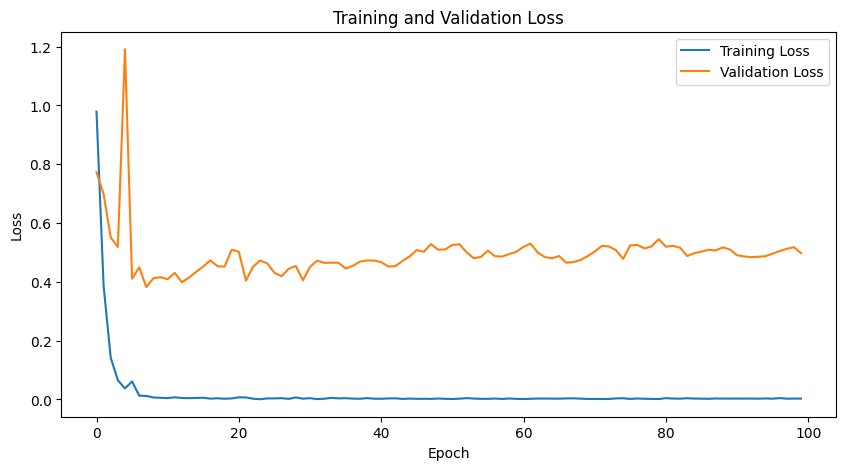

In [ ]:
# Fungsi untuk menyimpan checkpoint
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    print(f"Checkpoint saved at {filename}")

# Fungsi untuk memuat checkpoint
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    valid_losses = checkpoint['valid_losses']
    print(f"Checkpoint loaded from {filename}, starting at epoch {start_epoch}")
    return start_epoch, train_losses, valid_losses

# Optimizer dan fungsi loss
# Definisikan optimizer dengan L2 regularization (weight decay)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

# Variables to track time
total_training_time = 0
total_testing_time = 0

# Training loop with checkpoint, metrics, and timing
num_epochs = 100
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

start_epoch = 0
checkpoint_file = 'checkpoint.pth.tar'
if os.path.exists(checkpoint_file):
    start_epoch, train_losses, valid_losses = load_checkpoint(checkpoint_file)

# Start total training time
training_start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    epoch_start_time = time.time()  # Start time for each epoch

    model.train()
    train_loss = 0
    true_labels_train = []
    predicted_labels_train = []

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        if images.dim() == 3:
            images = images.unsqueeze(1)
        images = images.repeat(1, 3, 1, 1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Collect labels for metrics calculation
        predicted_labels_train.append(torch.argmax(outputs, dim=1))
        true_labels_train.append(labels)

        train_loader_tqdm.set_postfix({"Loss": loss.item()})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Combine all predicted and true labels
    predicted_labels_train = torch.cat(predicted_labels_train)
    true_labels_train = torch.cat(true_labels_train)

    # Calculate metrics for training data
    train_accuracy = (predicted_labels_train == true_labels_train).float().mean().item()
    train_precision = precision_score(true_labels_train.cpu(), predicted_labels_train.cpu(), average='weighted', zero_division=1)
    train_recall = recall_score(true_labels_train.cpu(), predicted_labels_train.cpu(), average='weighted', zero_division=1)
    train_f1 = f1_score(true_labels_train.cpu(), predicted_labels_train.cpu(), average='weighted', zero_division=1)

    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}')

    # Validation
    valid_loss = 0
    model.eval()
    true_labels_valid = []
    predicted_labels_valid = []

    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
    with torch.no_grad():
        for images, labels in valid_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            if images.dim() == 3:
                images = images.unsqueeze(1)
            images = images.repeat(1, 3, 1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            # Collect labels for metrics calculation
            predicted_labels_valid.append(torch.argmax(outputs, dim=1))
            true_labels_valid.append(labels)

            valid_loader_tqdm.set_postfix({"Loss": loss.item()})

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    # Combine all predicted and true labels
    predicted_labels_valid = torch.cat(predicted_labels_valid)
    true_labels_valid = torch.cat(true_labels_valid)

    # Calculate metrics for validation data
    valid_accuracy = (predicted_labels_valid == true_labels_valid).float().mean().item()
    valid_precision = precision_score(true_labels_valid.cpu(), predicted_labels_valid.cpu(), average='weighted', zero_division=1)
    valid_recall = recall_score(true_labels_valid.cpu(), predicted_labels_valid.cpu(), average='weighted', zero_division=1)
    valid_f1 = f1_score(true_labels_valid.cpu(), predicted_labels_valid.cpu(), average='weighted', zero_division=1)

    valid_accuracies.append(valid_accuracy)

    print(f'Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}, F1-Score: {valid_f1:.4f}')



    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model-vgg-clahe-0,001.pth')

    # Save checkpoint every epoch
    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_losses': train_losses,
        'valid_losses': valid_losses,
    }
    save_checkpoint(checkpoint, checkpoint_file)

    # Calculate epoch time and add to total training time
    epoch_time = time.time() - epoch_start_time
    total_training_time += epoch_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds")

# End total training time
total_training_time = time.time() - training_start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

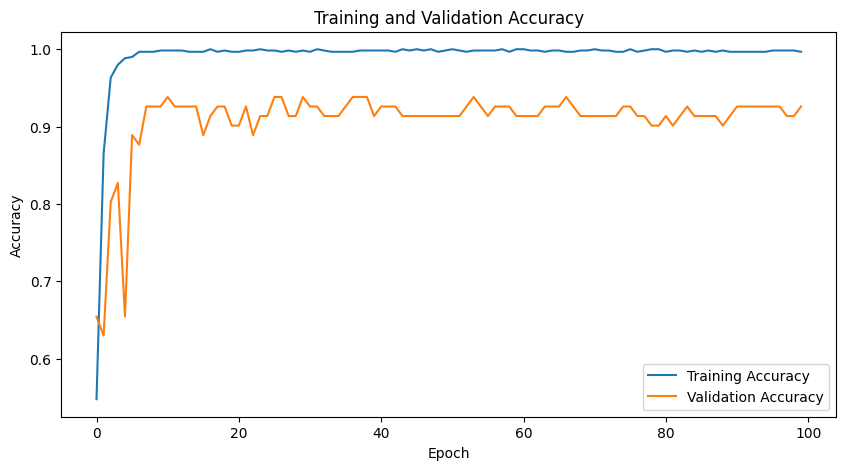

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:

# Hitung rata-rata metrik setelah semua epoch
average_train_loss = np.mean(train_losses)
average_valid_loss = np.mean(valid_losses)
average_train_accuracy = np.mean(train_accuracies)
average_valid_accuracy = np.mean(valid_accuracies)
average_train_precision = np.mean(train_precision)
average_valid_precision = np.mean(valid_precision)
average_train_recall = np.mean(train_recall)
average_valid_recall = np.mean(valid_recall)
average_train_f1 = np.mean(train_f1)
average_valid_f1 = np.mean(valid_f1)


# Display results training
print('--------------')
print(f'Training Accuracy: {average_train_accuracy * 100:.2f}%')
print(f'Training Loss: {average_train_loss:.4f}')
print(f'Training Precision: {average_train_precision:.4f}')
print(f'Training Recall: {average_train_recall:.4f}')
print(f'Training F1-Score: {average_train_f1:.4f}')


# Display results validasi
print('--------------')
print(f'Validation Accuracy: {average_valid_accuracy * 100:.2f}%')
print(f'Validation Loss: {average_valid_loss:.4f}')
print(f'Validation Precision: {average_valid_precision:.4f}')
print(f'Validation Recall: {average_valid_recall:.4f}')
print(f'Validation F1-Score: {average_valid_f1:.4f}')

--------------
Training Accuracy: 99.14%
Training Loss: 0.0200
Training Precision: 0.9967
Training Recall: 0.9967
Training F1-Score: 0.9967
--------------
Validation Accuracy: 90.84%
Validation Loss: 0.4930
Validation Precision: 0.9408
Validation Recall: 0.9259
Validation F1-Score: 0.9286


# Cell 6: Model Evaluation with Additional Metrics
"""
This cell evaluates the best model using accuracy, precision, recall, F1-score, and confusion matrix.
These metrics provide a comprehensive understanding of the model's performance on the test dataset.
"""

<ipython-input-13-d8a6ad25dfac>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-model-vgg-clahe-0,001.pth'))
Testing: 100%|██████████

Total testing time: 1.57 seconds
Test Accuracy: 87.62%
Test Loss: 0.0353
Precision: 0.8993
Recall: 0.8762
F1-Score: 0.8781
Confusion Matrix:
[[91 19  0 10]
 [ 0 51  0  0]
 [ 1  0 53  0]
 [ 3  6  0 81]]


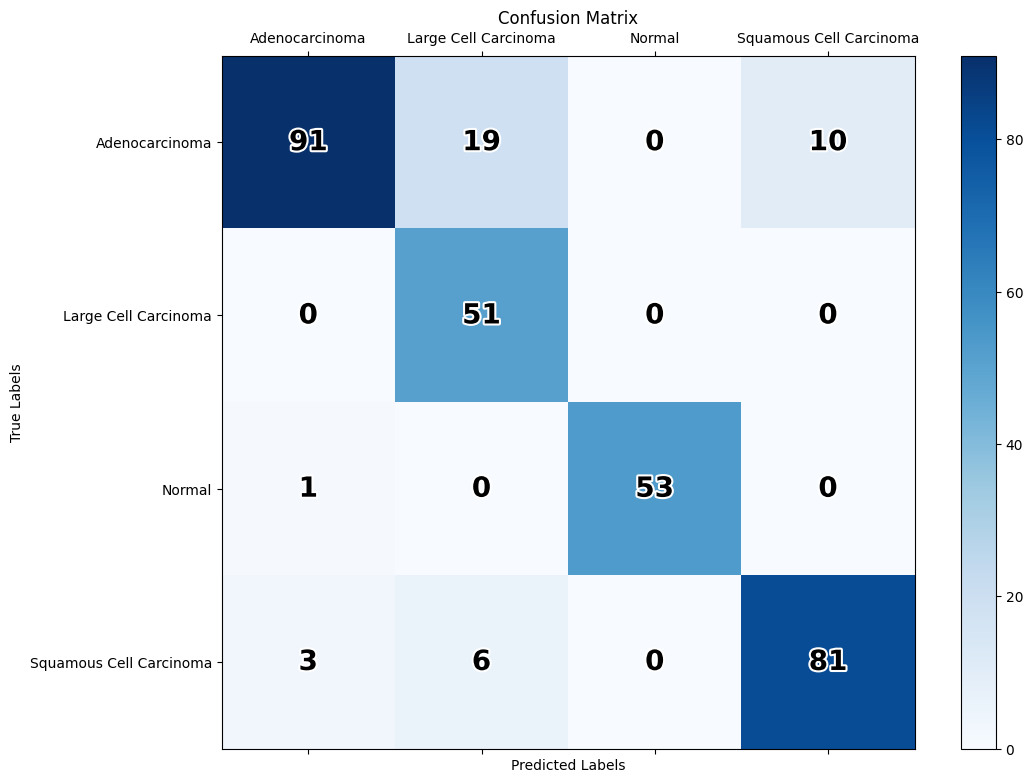

Total process time (training + testing): 1015.01 seconds


In [ ]:
# Path dinamis untuk memuat model terbaik
best_model_file = '/content/drive/MyDrive/Chest-CT-Data/best-model-vgg-clahe-0,001.pth' if IN_COLAB else 'best-model.pth'
# Start testing time
testing_start_time = time.time()

# Load the best model
model.load_state_dict(torch.load('best-model-vgg-clahe-0,001.pth'))
model.eval()

# Define class labels corresponding to the numerical labels
class_labels = [
    'Adenocarcinoma',
    'Large Cell Carcinoma',
    'Normal',
    'Squamous Cell Carcinoma'
]

predicted_probabilities = []
true_labels = []

test_loader_tqdm = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for images, labels in test_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        if images.dim() == 3:
            images = images.unsqueeze(1)
        images = images.repeat(1, 3, 1, 1)
        outputs = model(images)
        probabilities = nn.functional.softmax(outputs, dim=1)
        predicted_probabilities.append(probabilities)
        true_labels.append(labels)
        #test_loader_tqdm.set_postfix({"Batch Size": len(labels)})

# End testing time
total_testing_time = time.time() - testing_start_time
print(f"Total testing time: {total_testing_time:.2f} seconds")

# Calculate evaluation metrics
predicted_probabilities = torch.cat(predicted_probabilities)
true_labels = torch.cat(true_labels)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

accuracy = (predicted_labels == true_labels).float().mean().item()
precision = precision_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
recall = recall_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
f1 = f1_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
conf_matrix = confusion_matrix(true_labels.cpu(), predicted_labels.cpu())

# Display results
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Loss: {loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(12, 9))
cax = ax.matshow(conf_matrix, cmap='Blues')

# Menampilkan angka pada setiap sel dengan outline putih
for (i, j), val in np.ndenumerate(conf_matrix):
    text = ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=20, fontweight='bold')

    # Menambahkan outline putih di sekitar angka
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])

fig.colorbar(cax)

# Set ticks dan ticklabels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Total time for the whole process
total_process_time = total_training_time + total_testing_time
print(f"Total process time (training + testing): {total_process_time:.2f} seconds")


Kesimpulan dari percobaan ini: saat dataset yang di preprocessing dengan **Gaussian + Gaussian blur + USM + VGG16 AS FEATURE EXTRACTION + ADD CLASIFICATION LAYER + Adam Optimizer** saja yaitu, hasil akurasi test = Test Accuracy: 72.38%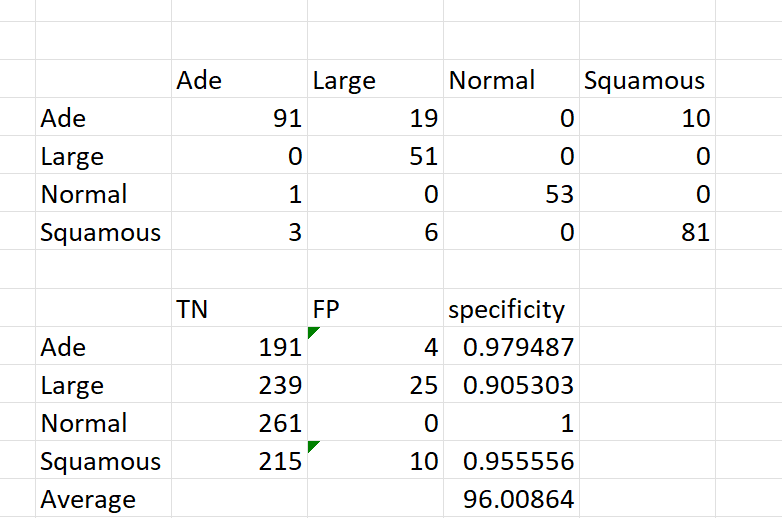